In [1]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Any, Callable

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

train_file_path = r"C:\Users\26069\Downloads\train_data_after_feature_selection.csv"
chunkSize = 1000000
train = pd.DataFrame()

for chunk in tqdm(pd.read_csv(train_file_path, iterator=True, chunksize=chunkSize)):
  train = pd.concat([train, chunk], ignore_index=True)

test_file_path = r"C:\Users\26069\Downloads\test_data_after_feature_selection.csv"
chunkSize = 1000000
test = pd.DataFrame()

for chunk in tqdm(pd.read_csv(test_file_path, iterator=True, chunksize=chunkSize)):
  test = pd.concat([test, chunk], ignore_index=True)


4it [00:03,  1.19it/s]
1it [00:00, 32.26it/s]


In [3]:
#print(df)

In [4]:
print(train.shape)
print(train['label'].value_counts())
print(test.shape)
print(test['label'].value_counts())

(3813974, 23)
label
0    3766407
1      47567
Name: count, dtype: int64
(23784, 23)
label
1    11892
0    11892
Name: count, dtype: int64


In [5]:
X_train = train.drop(columns=['label']) 
y_train = train['label']                 
X_test = test.drop(columns=['label'])    
y_test = test['label']

In [6]:
from diffprivlib.models import GaussianNB
#from sklearn.preprocessing import StandardScaler

# Normalize the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#what if i don't scale
X_train_scaled = X_train
X_test_scaled = X_test

# Apply Differential Privacy to model training
clf = GaussianNB(epsilon=0.01)  # Adjust epsilon for desired privacy level
clf.fit(X_train_scaled, y_train)

# Evaluate the model
print("DP GaussianNB Test Accuracy:", clf.score(X_test_scaled, y_test))


C:\Users\26069\anaconda3\Lib\site-packages\diffprivlib\models\naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


DP GaussianNB Test Accuracy: 0.5069794820047091


In [7]:
print(X_train_scaled.shape)
print(X_train_scaled)

(3813974, 22)
         city  series_dev  emui_dev  device_name  device_size  net_type  \
0         411          16        35          324         2401         7   
1         306          30        35          278         2482         7   
2         106          21        12          310         2231         7   
3         431          32        19          312         1135         7   
4         263          30        28          344         2032         7   
...       ...         ...       ...          ...          ...       ...   
3813969   372          21        30          338         2305         7   
3813970   352          34        28          280         2117         7   
3813971   297          19        30          228         1786         7   
3813972   328          20        19          190         1704         6   
3813973   319          27        11          319         2117         7   

         creat_type_cd  slot_id  spread_app_id  app_second_class  ...  \
0           

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# epsilons = np.logspace(-2, 2, 50)  # Epsilon values ranging from 0.01 to 100
# accuracy = list()

# for epsilon in epsilons:
#     clf = GaussianNB(epsilon=epsilon)
#     clf.fit(X_train_scaled, y_train)  # Use normalized train data
    
#     accuracy.append(clf.score(X_test_scaled, y_test))  # Evaluate on normalized test data

# plt.semilogx(epsilons, accuracy)
# plt.title("Differentially private Naive Bayes accuracy")
# plt.xlabel("epsilon (Privacy Level)")
# plt.ylabel("Accuracy")
# plt.show()


util

In [10]:
# @title
import torch
import numpy as np
import torch.nn.functional as F
from torch.profiler import record_function
from inspect import isfunction

def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.

    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

def sum_except_batch(x, num_dims=1):
    '''
    Sums all dimensions except the first.

    Args:
        x: Tensor, shape (batch_size, ...)
        num_dims: int, number of batch dims (default=1)

    Returns:
        x_sum: Tensor, shape (batch_size,)
    '''
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def ohe_to_categories(ohe, K):
    K = torch.from_numpy(K)
    indices = torch.cat([torch.zeros((1,)), K.cumsum(dim=0)], dim=0).int().tolist()
    res = []
    for i in range(len(indices) - 1):
        res.append(ohe[:, indices[i]:indices[i+1]].argmax(dim=1))
    return torch.stack(res, dim=1)

def log_1_min_a(a):
    return torch.log(1 - a.exp() + 1e-40)


def log_add_exp(a, b):
    maximum = torch.max(a, b)
    return maximum + torch.log(torch.exp(a - maximum) + torch.exp(b - maximum))

def exists(x):
    return x is not None

def extract(a, t, x_shape):
    b, *_ = t.shape
    t = t.to(a.device)
    out = a.gather(-1, t)
    while len(out.shape) < len(x_shape):
        out = out[..., None]
    return out.expand(x_shape)

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def log_categorical(log_x_start, log_prob):
    return (log_x_start.exp() * log_prob).sum(dim=1)

def index_to_log_onehot(x, num_classes):
    onehots = []
    for i in range(len(num_classes)):
        onehots.append(F.one_hot(x[:, i], num_classes[i]))

    x_onehot = torch.cat(onehots, dim=1)
    log_onehot = torch.log(x_onehot.float().clamp(min=1e-30))
    return log_onehot

def log_sum_exp_by_classes(x, slices):
    device = x.device
    res = torch.zeros_like(x)
    for ixs in slices:
        res[:, ixs] = torch.logsumexp(x[:, ixs], dim=1, keepdim=True)

    assert x.size() == res.size()

    return res

@torch.jit.script
def log_sub_exp(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    m = torch.maximum(a, b)
    return torch.log(torch.exp(a - m) - torch.exp(b - m)) + m

@torch.jit.script
def sliced_logsumexp(x, slices):
    lse = torch.logcumsumexp(
        torch.nn.functional.pad(x, [1, 0, 0, 0], value=-float('inf')),
        dim=-1)

    slice_starts = slices[:-1]
    slice_ends = slices[1:]

    slice_lse = log_sub_exp(lse[:, slice_ends], lse[:, slice_starts])
    slice_lse_repeated = torch.repeat_interleave(
        slice_lse,
        slice_ends - slice_starts,
        dim=-1
    )
    return slice_lse_repeated

def log_onehot_to_index(log_x):
    return log_x.argmax(1)

class FoundNANsError(BaseException):
    """Found NANs during sampling"""
    def __init__(self, message='Found NANs during sampling.'):
        super(FoundNANsError, self).__init__(message)

model

In [12]:
# @title
"""
Code was adapted from https://github.com/Yura52/rtdl
"""

import math
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor

ModuleType = Union[str, Callable[..., nn.Module]]

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

def _is_glu_activation(activation: ModuleType):
    return (
        isinstance(activation, str)
        and activation.endswith('GLU')
        or activation in [ReGLU, GEGLU]
    )


def _all_or_none(values):
    assert all(x is None for x in values) or all(x is not None for x in values)

def reglu(x: Tensor) -> Tensor:
    """The ReGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)


def geglu(x: Tensor) -> Tensor:
    """The GEGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.gelu(b)

class ReGLU(nn.Module):
    """The ReGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = ReGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)


class GEGLU(nn.Module):
    """The GEGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = GEGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return geglu(x)

def _make_nn_module(module_type: ModuleType, *args) -> nn.Module:
    return (
        (
            ReGLU()
            if module_type == 'ReGLU'
            else GEGLU()
            if module_type == 'GEGLU'
            else getattr(nn, module_type)(*args)
        )
        if isinstance(module_type, str)
        else module_type(*args)
    )


class MLP(nn.Module):
    """The MLP model used in [gorishniy2021revisiting].

    The following scheme describes the architecture:

    .. code-block:: text

          MLP: (in) -> Block -> ... -> Block -> Linear -> (out)
        Block: (in) -> Linear -> Activation -> Dropout -> (out)

    Examples:
        .. testcode::

            x = torch.randn(4, 2)
            module = MLP.make_baseline(x.shape[1], [3, 5], 0.1, 1)
            assert module(x).shape == (len(x), 1)

    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `MLP`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            activation: ModuleType,
            dropout: float,
        ) -> None:
            super().__init__()
            self.linear = nn.Linear(d_in, d_out, bias)
            self.activation = _make_nn_module(activation)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: Tensor) -> Tensor:
            return self.dropout(self.activation(self.linear(x)))

    def __init__(
        self,
        *,
        d_in: int,
        d_layers: List[int],
        dropouts: Union[float, List[float]],
        activation: Union[str, Callable[[], nn.Module]],
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()
        if isinstance(dropouts, float):
            dropouts = [dropouts] * len(d_layers)
        assert len(d_layers) == len(dropouts)
        assert activation not in ['ReGLU', 'GEGLU']

        self.blocks = nn.ModuleList(
            [
                MLP.Block(
                    d_in=d_layers[i - 1] if i else d_in,
                    d_out=d,
                    bias=True,
                    activation=activation,
                    dropout=dropout,
                )
                for i, (d, dropout) in enumerate(zip(d_layers, dropouts))
            ]
        )
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    @classmethod
    def make_baseline(
        cls: Type['MLP'],
        d_in: int,
        d_layers: List[int],
        dropout: float,
        d_out: int,
    ) -> 'MLP':
        """Create a "baseline" `MLP`.

        This variation of MLP was used in [gorishniy2021revisiting]. Features:

        * :code:`Activation` = :code:`ReLU`
        * all linear layers except for the first one and the last one are of the same dimension
        * the dropout rate is the same for all dropout layers

        Args:
            d_in: the input size
            d_layers: the dimensions of the linear layers. If there are more than two
                layers, then all of them except for the first and the last ones must
                have the same dimension. Valid examples: :code:`[]`, :code:`[8]`,
                :code:`[8, 16]`, :code:`[2, 2, 2, 2]`, :code:`[1, 2, 2, 4]`. Invalid
                example: :code:`[1, 2, 3, 4]`.
            dropout: the dropout rate for all hidden layers
            d_out: the output size
        Returns:
            MLP

        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        assert isinstance(dropout, float)
        if len(d_layers) > 2:
            assert len(set(d_layers[1:-1])) == 1, (
                'if d_layers contains more than two elements, then'
                ' all elements except for the first and the last ones must be equal.'
            )
        return MLP(
            d_in=d_in,
            d_layers=d_layers,  # type: ignore
            dropouts=dropout,
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x


class ResNet(nn.Module):
    """The ResNet model used in [gorishniy2021revisiting].
    The following scheme describes the architecture:
    .. code-block:: text
        ResNet: (in) -> Linear -> Block -> ... -> Block -> Head -> (out)
                 |-> Norm -> Linear -> Activation -> Dropout -> Linear -> Dropout ->|
                 |                                                                  |
         Block: (in) ------------------------------------------------------------> Add -> (out)
          Head: (in) -> Norm -> Activation -> Linear -> (out)
    Examples:
        .. testcode::
            x = torch.randn(4, 2)
            module = ResNet.make_baseline(
                d_in=x.shape[1],
                n_blocks=2,
                d_main=3,
                d_hidden=4,
                dropout_first=0.25,
                dropout_second=0.0,
                d_out=1
            )
            assert module(x).shape == (len(x), 1)
    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `ResNet`."""

        def __init__(
            self,
            *,
            d_main: int,
            d_hidden: int,
            bias_first: bool,
            bias_second: bool,
            dropout_first: float,
            dropout_second: float,
            normalization: ModuleType,
            activation: ModuleType,
            skip_connection: bool,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_main)
            self.linear_first = nn.Linear(d_main, d_hidden, bias_first)
            self.activation = _make_nn_module(activation)
            self.dropout_first = nn.Dropout(dropout_first)
            self.linear_second = nn.Linear(d_hidden, d_main, bias_second)
            self.dropout_second = nn.Dropout(dropout_second)
            self.skip_connection = skip_connection

        def forward(self, x: Tensor) -> Tensor:
            x_input = x
            x = self.normalization(x)
            x = self.linear_first(x)
            x = self.activation(x)
            x = self.dropout_first(x)
            x = self.linear_second(x)
            x = self.dropout_second(x)
            if self.skip_connection:
                x = x_input + x
            return x

    class Head(nn.Module):
        """The final module of `ResNet`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            normalization: ModuleType,
            activation: ModuleType,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_in)
            self.activation = _make_nn_module(activation)
            self.linear = nn.Linear(d_in, d_out, bias)

        def forward(self, x: Tensor) -> Tensor:
            if self.normalization is not None:
                x = self.normalization(x)
            x = self.activation(x)
            x = self.linear(x)
            return x

    def __init__(
        self,
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        normalization: ModuleType,
        activation: ModuleType,
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()

        self.first_layer = nn.Linear(d_in, d_main)
        if d_main is None:
            d_main = d_in
        self.blocks = nn.Sequential(
            *[
                ResNet.Block(
                    d_main=d_main,
                    d_hidden=d_hidden,
                    bias_first=True,
                    bias_second=True,
                    dropout_first=dropout_first,
                    dropout_second=dropout_second,
                    normalization=normalization,
                    activation=activation,
                    skip_connection=True,
                )
                for _ in range(n_blocks)
            ]
        )
        self.head = ResNet.Head(
            d_in=d_main,
            d_out=d_out,
            bias=True,
            normalization=normalization,
            activation=activation,
        )

    @classmethod
    def make_baseline(
        cls: Type['ResNet'],
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        d_out: int,
    ) -> 'ResNet':
        """Create a "baseline" `ResNet`.
        This variation of ResNet was used in [gorishniy2021revisiting]. Features:
        * :code:`Activation` = :code:`ReLU`
        * :code:`Norm` = :code:`BatchNorm1d`
        Args:
            d_in: the input size
            n_blocks: the number of Blocks
            d_main: the input size (or, equivalently, the output size) of each Block
            d_hidden: the output size of the first linear layer in each Block
            dropout_first: the dropout rate of the first dropout layer in each Block.
            dropout_second: the dropout rate of the second dropout layer in each Block.
        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        return cls(
            d_in=d_in,
            n_blocks=n_blocks,
            d_main=d_main,
            d_hidden=d_hidden,
            dropout_first=dropout_first,
            dropout_second=dropout_second,
            normalization='BatchNorm1d',
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        x = self.first_layer(x)
        x = self.blocks(x)
        x = self.head(x)
        return x
#### For diffusion

class MLPDiffusion(nn.Module):
    def __init__(self, d_in, num_classes, is_y_cond, rtdl_params, dim_t = 128):
        super().__init__()
        self.dim_t = dim_t
        self.num_classes = num_classes
        self.is_y_cond = is_y_cond

        # d0 = rtdl_params['d_layers'][0]

        rtdl_params['d_in'] = dim_t
        rtdl_params['d_out'] = d_in

        self.mlp = MLP.make_baseline(**rtdl_params)

        if self.num_classes > 0 and is_y_cond:
            self.label_emb = nn.Embedding(self.num_classes, dim_t)
        elif self.num_classes == 0 and is_y_cond:
            self.label_emb = nn.Linear(1, dim_t)

        self.proj = nn.Linear(d_in, dim_t)
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

    def forward(self, x, timesteps, y=None):
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))
        if self.is_y_cond and y is not None:
            if self.num_classes > 0:
                y = y.squeeze()
            else:
                y = y.resize(y.size(0), 1).float()
            emb += F.silu(self.label_emb(y))
        x = self.proj(x) + emb
        return self.mlp(x)

class ResNetDiffusion(nn.Module):
    def __init__(self, d_in, num_classes, rtdl_params, dim_t = 256):
        super().__init__()
        self.dim_t = dim_t
        self.num_classes = num_classes

        rtdl_params['d_in'] = d_in
        rtdl_params['d_out'] = d_in
        rtdl_params['emb_d'] = dim_t
        self.resnet = ResNet.make_baseline(**rtdl_params)

        if self.num_classes > 0:
            self.label_emb = nn.Embedding(self.num_classes, dim_t)

        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

    def forward(self, x, timesteps, y=None):
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))
        if y is not None and self.num_classes > 0:
            emb += self.label_emb(y.squeeze())
        return self.resnet(x, emb)


gaussian_multinomial_diffsuion

In [14]:
# @title
"""
Based on https://github.com/openai/guided-diffusion/blob/main/guided_diffusion
and https://github.com/ehoogeboom/multinomial_diffusion
"""

import torch.nn.functional as F
import torch
import math

import numpy as np
#from .utils import *

"""
Based in part on: https://github.com/lucidrains/denoising-diffusion-pytorch/blob/5989f4c77eafcdc6be0fb4739f0f277a6dd7f7d8/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L281
"""
eps = 1e-8

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

class GaussianMultinomialDiffusion(torch.nn.Module):
    def __init__(
            self,
            num_classes: np.array,
            num_numerical_features: int,
            denoise_fn,
            num_timesteps=1000,
            gaussian_loss_type='mse',
            gaussian_parametrization='eps',
            multinomial_loss_type='vb_stochastic',
            parametrization='x0',
            scheduler='cosine',
            device=torch.device('cpu')
        ):

        super(GaussianMultinomialDiffusion, self).__init__()
        assert multinomial_loss_type in ('vb_stochastic', 'vb_all')
        assert parametrization in ('x0', 'direct')

        if multinomial_loss_type == 'vb_all':
            print('Computing the loss using the bound on _all_ timesteps.'
                  ' This is expensive both in terms of memory and computation.')

        self.num_numerical_features = num_numerical_features
        self.num_classes = num_classes # it as a vector [K1, K2, ..., Km]
        self.num_classes_expanded = torch.from_numpy(
            np.concatenate([num_classes[i].repeat(num_classes[i]) for i in range(len(num_classes))])
        ).to(device)

        self.slices_for_classes = [np.arange(self.num_classes[0])]
        offsets = np.cumsum(self.num_classes)
        for i in range(1, len(offsets)):
            self.slices_for_classes.append(np.arange(offsets[i - 1], offsets[i]))
        self.offsets = torch.from_numpy(np.append([0], offsets)).to(device)

        self._denoise_fn = denoise_fn
        self.gaussian_loss_type = gaussian_loss_type
        self.gaussian_parametrization = gaussian_parametrization
        self.multinomial_loss_type = multinomial_loss_type
        self.num_timesteps = num_timesteps
        self.parametrization = parametrization
        self.scheduler = scheduler

        alphas = 1. - get_named_beta_schedule(scheduler, num_timesteps)
        alphas = torch.tensor(alphas.astype('float64'))
        betas = 1. - alphas

        log_alpha = np.log(alphas)
        log_cumprod_alpha = np.cumsum(log_alpha)

        log_1_min_alpha = log_1_min_a(log_alpha)
        log_1_min_cumprod_alpha = log_1_min_a(log_cumprod_alpha)

        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = torch.tensor(np.append(1.0, alphas_cumprod[:-1]))
        alphas_cumprod_next = torch.tensor(np.append(alphas_cumprod[1:], 0.0))
        sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
        sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
        sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)

        # Gaussian diffusion

        self.posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_log_variance_clipped = torch.from_numpy(
            np.log(np.append(self.posterior_variance[1], self.posterior_variance[1:]))
        ).float().to(device)
        self.posterior_mean_coef1 = (
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        ).float().to(device)
        self.posterior_mean_coef2 = (
            (1.0 - alphas_cumprod_prev)
            * np.sqrt(alphas.numpy())
            / (1.0 - alphas_cumprod)
        ).float().to(device)

        assert log_add_exp(log_alpha, log_1_min_alpha).abs().sum().item() < 1.e-5
        assert log_add_exp(log_cumprod_alpha, log_1_min_cumprod_alpha).abs().sum().item() < 1e-5
        assert (np.cumsum(log_alpha) - log_cumprod_alpha).abs().sum().item() < 1.e-5

        # Convert to float32 and register buffers.
        self.register_buffer('alphas', alphas.float().to(device))
        self.register_buffer('log_alpha', log_alpha.float().to(device))
        self.register_buffer('log_1_min_alpha', log_1_min_alpha.float().to(device))
        self.register_buffer('log_1_min_cumprod_alpha', log_1_min_cumprod_alpha.float().to(device))
        self.register_buffer('log_cumprod_alpha', log_cumprod_alpha.float().to(device))
        self.register_buffer('alphas_cumprod', alphas_cumprod.float().to(device))
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev.float().to(device))
        self.register_buffer('alphas_cumprod_next', alphas_cumprod_next.float().to(device))
        self.register_buffer('sqrt_alphas_cumprod', sqrt_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', sqrt_one_minus_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_recip_alphas_cumprod', sqrt_recip_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', sqrt_recipm1_alphas_cumprod.float().to(device))

        self.register_buffer('Lt_history', torch.zeros(num_timesteps))
        self.register_buffer('Lt_count', torch.zeros(num_timesteps))

    # Gaussian part
    def gaussian_q_mean_variance(self, x_start, t):
        mean = (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        )
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(
            self.log_1_min_cumprod_alpha, t, x_start.shape
        )
        return mean, variance, log_variance

    def gaussian_q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def gaussian_q_posterior_mean_variance(self, x_start, x_t, t):
        assert x_start.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def gaussian_p_mean_variance(
        self, model_output, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None
    ):
        if model_kwargs is None:
            model_kwargs = {}

        B, C = x.shape[:2]
        assert t.shape == (B,)

        model_variance = torch.cat([self.posterior_variance[1].unsqueeze(0).to(x.device), (1. - self.alphas)[1:]], dim=0)
        # model_variance = self.posterior_variance.to(x.device)
        model_log_variance = torch.log(model_variance)

        model_variance = extract(model_variance, t, x.shape)
        model_log_variance = extract(model_log_variance, t, x.shape)


        if self.gaussian_parametrization == 'eps':
            pred_xstart = self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
        elif self.gaussian_parametrization == 'x0':
            pred_xstart = model_output
        else:
            raise NotImplementedError

        model_mean, _, _ = self.gaussian_q_posterior_mean_variance(
            x_start=pred_xstart, x_t=x, t=t
        )

        assert (
            model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        ), f'{model_mean.shape}, {model_log_variance.shape}, {pred_xstart.shape}, {x.shape}'

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _vb_terms_bpd(
        self, model_output, x_start, x_t, t, clip_denoised=False, model_kwargs=None
    ):
        true_mean, _, true_log_variance_clipped = self.gaussian_q_posterior_mean_variance(
            x_start=x_start, x_t=x_t, t=t
        )
        out = self.gaussian_p_mean_variance(
            model_output, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = torch.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"], "out_mean": out["mean"], "true_mean": true_mean}

    def _prior_gaussian(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.

        This term can't be optimized, as it only depends on the encoder.

        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.gaussian_q_mean_variance(x_start, t)
        kl_prior = normal_kl(
            mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
        )
        return mean_flat(kl_prior) / np.log(2.0)

    def _gaussian_loss(self, model_out, x_start, x_t, t, noise, model_kwargs=None):
        if model_kwargs is None:
            model_kwargs = {}

        terms = {}
        if self.gaussian_loss_type == 'mse':
            terms["loss"] = mean_flat((noise - model_out) ** 2)
        elif self.gaussian_loss_type == 'kl':
            terms["loss"] = self._vb_terms_bpd(
                model_output=model_out,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )["output"]


        return terms['loss']

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - pred_xstart
        ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def gaussian_p_sample(
        self,
        model_out,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        model_kwargs=None,
    ):
        out = self.gaussian_p_mean_variance(
            model_out,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0

        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    # Multinomial part

    def multinomial_kl(self, log_prob1, log_prob2):
        kl = (log_prob1.exp() * (log_prob1 - log_prob2)).sum(dim=1)
        return kl

    def q_pred_one_timestep(self, log_x_t, t):
        log_alpha_t = extract(self.log_alpha, t, log_x_t.shape)
        log_1_min_alpha_t = extract(self.log_1_min_alpha, t, log_x_t.shape)

        # alpha_t * E[xt] + (1 - alpha_t) 1 / K
        log_probs = log_add_exp(
            log_x_t + log_alpha_t,
            log_1_min_alpha_t - torch.log(self.num_classes_expanded)
        )

        return log_probs

    def q_pred(self, log_x_start, t):
        log_cumprod_alpha_t = extract(self.log_cumprod_alpha, t, log_x_start.shape)
        log_1_min_cumprod_alpha = extract(self.log_1_min_cumprod_alpha, t, log_x_start.shape)

        log_probs = log_add_exp(
            log_x_start + log_cumprod_alpha_t,
            log_1_min_cumprod_alpha - torch.log(self.num_classes_expanded)
        )

        return log_probs

    def predict_start(self, model_out, log_x_t, t, out_dict):

        # model_out = self._denoise_fn(x_t, t.to(x_t.device), **out_dict)

        assert model_out.size(0) == log_x_t.size(0)
        assert model_out.size(1) == self.num_classes.sum(), f'{model_out.size()}'

        log_pred = torch.empty_like(model_out)
        for ix in self.slices_for_classes:
            log_pred[:, ix] = F.log_softmax(model_out[:, ix], dim=1)
        return log_pred

    def q_posterior(self, log_x_start, log_x_t, t):
        # q(xt-1 | xt, x0) = q(xt | xt-1, x0) * q(xt-1 | x0) / q(xt | x0)
        # where q(xt | xt-1, x0) = q(xt | xt-1).

        # EV_log_qxt_x0 = self.q_pred(log_x_start, t)

        # print('sum exp', EV_log_qxt_x0.exp().sum(1).mean())
        # assert False

        # log_qxt_x0 = (log_x_t.exp() * EV_log_qxt_x0).sum(dim=1)
        t_minus_1 = t - 1
        # Remove negative values, will not be used anyway for final decoder
        t_minus_1 = torch.where(t_minus_1 < 0, torch.zeros_like(t_minus_1), t_minus_1)
        log_EV_qxtmin_x0 = self.q_pred(log_x_start, t_minus_1)

        num_axes = (1,) * (len(log_x_start.size()) - 1)
        t_broadcast = t.to(log_x_start.device).view(-1, *num_axes) * torch.ones_like(log_x_start)
        log_EV_qxtmin_x0 = torch.where(t_broadcast == 0, log_x_start, log_EV_qxtmin_x0.to(torch.float32))

        # unnormed_logprobs = log_EV_qxtmin_x0 +
        #                     log q_pred_one_timestep(x_t, t)
        # Note: _NOT_ x_tmin1, which is how the formula is typically used!!!
        # Not very easy to see why this is true. But it is :)
        unnormed_logprobs = log_EV_qxtmin_x0 + self.q_pred_one_timestep(log_x_t, t)

        log_EV_xtmin_given_xt_given_xstart = \
            unnormed_logprobs \
            - sliced_logsumexp(unnormed_logprobs, self.offsets)

        return log_EV_xtmin_given_xt_given_xstart

    def p_pred(self, model_out, log_x, t, out_dict):
        if self.parametrization == 'x0':
            log_x_recon = self.predict_start(model_out, log_x, t=t, out_dict=out_dict)
            log_model_pred = self.q_posterior(
                log_x_start=log_x_recon, log_x_t=log_x, t=t)
        elif self.parametrization == 'direct':
            log_model_pred = self.predict_start(model_out, log_x, t=t, out_dict=out_dict)
        else:
            raise ValueError
        return log_model_pred

    @torch.no_grad()
    def p_sample(self, model_out, log_x, t, out_dict):
        model_log_prob = self.p_pred(model_out, log_x=log_x, t=t, out_dict=out_dict)
        out = self.log_sample_categorical(model_log_prob)
        return out

    @torch.no_grad()
    def p_sample_loop(self, shape, out_dict):
        device = self.log_alpha.device

        b = shape[0]
        # start with random normal image.
        img = torch.randn(shape, device=device)

        for i in reversed(range(1, self.num_timesteps)):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long), out_dict)
        return img

    @torch.no_grad()
    def _sample(self, image_size, out_dict, batch_size = 16):
        return self.p_sample_loop((batch_size, 3, image_size, image_size), out_dict)

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in reversed(range(0, t)):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))

        return img

    def log_sample_categorical(self, logits):
        full_sample = []
        for i in range(len(self.num_classes)):
            one_class_logits = logits[:, self.slices_for_classes[i]]
            uniform = torch.rand_like(one_class_logits)
            gumbel_noise = -torch.log(-torch.log(uniform + 1e-30) + 1e-30)
            sample = (gumbel_noise + one_class_logits).argmax(dim=1)
            full_sample.append(sample.unsqueeze(1))
        full_sample = torch.cat(full_sample, dim=1)
        log_sample = index_to_log_onehot(full_sample, self.num_classes)
        return log_sample

    def q_sample(self, log_x_start, t):
        log_EV_qxt_x0 = self.q_pred(log_x_start, t)

        log_sample = self.log_sample_categorical(log_EV_qxt_x0)

        return log_sample

    def nll(self, log_x_start, out_dict):
        b = log_x_start.size(0)
        device = log_x_start.device
        loss = 0
        for t in range(0, self.num_timesteps):
            t_array = (torch.ones(b, device=device) * t).long()

            kl = self.compute_Lt(
                log_x_start=log_x_start,
                log_x_t=self.q_sample(log_x_start=log_x_start, t=t_array),
                t=t_array,
                out_dict=out_dict)

            loss += kl

        loss += self.kl_prior(log_x_start)

        return loss

    def kl_prior(self, log_x_start):
        b = log_x_start.size(0)
        device = log_x_start.device
        ones = torch.ones(b, device=device).long()

        log_qxT_prob = self.q_pred(log_x_start, t=(self.num_timesteps - 1) * ones)
        log_half_prob = -torch.log(self.num_classes_expanded * torch.ones_like(log_qxT_prob))

        kl_prior = self.multinomial_kl(log_qxT_prob, log_half_prob)
        return sum_except_batch(kl_prior)

    def compute_Lt(self, model_out, log_x_start, log_x_t, t, out_dict, detach_mean=False):
        log_true_prob = self.q_posterior(
            log_x_start=log_x_start, log_x_t=log_x_t, t=t)
        log_model_prob = self.p_pred(model_out, log_x=log_x_t, t=t, out_dict=out_dict)

        if detach_mean:
            log_model_prob = log_model_prob.detach()

        kl = self.multinomial_kl(log_true_prob, log_model_prob)
        kl = sum_except_batch(kl)

        decoder_nll = -log_categorical(log_x_start, log_model_prob)
        decoder_nll = sum_except_batch(decoder_nll)

        mask = (t == torch.zeros_like(t)).float()
        loss = mask * decoder_nll + (1. - mask) * kl

        return loss

    def sample_time(self, b, device, method='uniform'):
        if method == 'importance':
            if not (self.Lt_count > 10).all():
                return self.sample_time(b, device, method='uniform')

            Lt_sqrt = torch.sqrt(self.Lt_history + 1e-10) + 0.0001
            Lt_sqrt[0] = Lt_sqrt[1]  # Overwrite decoder term with L1.
            pt_all = (Lt_sqrt / Lt_sqrt.sum()).to(device)

            t = torch.multinomial(pt_all, num_samples=b, replacement=True).to(device)

            pt = pt_all.gather(dim=0, index=t)

            return t, pt

        elif method == 'uniform':
            t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

            pt = torch.ones_like(t).float() / self.num_timesteps
            return t, pt
        else:
            raise ValueError

    def _multinomial_loss(self, model_out, log_x_start, log_x_t, t, pt, out_dict):

        if self.multinomial_loss_type == 'vb_stochastic':
            kl = self.compute_Lt(
                model_out, log_x_start, log_x_t, t, out_dict
            )
            kl_prior = self.kl_prior(log_x_start)
            # Upweigh loss term of the kl
            vb_loss = kl / pt + kl_prior

            return vb_loss

        elif self.multinomial_loss_type == 'vb_all':
            # Expensive, dont do it ;).
            # DEPRECATED
            return -self.nll(log_x_start)
        else:
            raise ValueError()

    def log_prob(self, x, out_dict):
        b, device = x.size(0), x.device
        if self.training:
            return self._multinomial_loss(x, out_dict)

        else:
            log_x_start = index_to_log_onehot(x, self.num_classes)

            t, pt = self.sample_time(b, device, 'importance')

            kl = self.compute_Lt(
                log_x_start, self.q_sample(log_x_start=log_x_start, t=t), t, out_dict)

            kl_prior = self.kl_prior(log_x_start)

            # Upweigh loss term of the kl
            loss = kl / pt + kl_prior

            return -loss

    def mixed_loss(self, x, out_dict):
        b = x.shape[0]
        device = x.device
        t, pt = self.sample_time(b, device, 'uniform')

        x_num = x[:, :self.num_numerical_features]
        x_cat = x[:, self.num_numerical_features:]

        x_num_t = x_num
        log_x_cat_t = x_cat
        if x_num.shape[1] > 0:
            noise = torch.randn_like(x_num)
            x_num_t = self.gaussian_q_sample(x_num, t, noise=noise)
        if x_cat.shape[1] > 0:
            log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
            log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)

        x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)

        model_out = self._denoise_fn(
            x_in,
            t,
            **out_dict
        )

        model_out_num = model_out[:, :self.num_numerical_features]
        model_out_cat = model_out[:, self.num_numerical_features:]

        loss_multi = torch.zeros((1,)).float()
        loss_gauss = torch.zeros((1,)).float()
        if x_cat.shape[1] > 0:
            loss_multi = self._multinomial_loss(model_out_cat, log_x_cat, log_x_cat_t, t, pt, out_dict) / len(self.num_classes)

        if x_num.shape[1] > 0:
            loss_gauss = self._gaussian_loss(model_out_num, x_num, x_num_t, t, noise)

        # loss_multi = torch.where(out_dict['y'] == 1, loss_multi, 2 * loss_multi)
        # loss_gauss = torch.where(out_dict['y'] == 1, loss_gauss, 2 * loss_gauss)

        return loss_multi.mean(), loss_gauss.mean()

    @torch.no_grad()
    def mixed_elbo(self, x0, out_dict):
        b = x0.size(0)
        device = x0.device

        x_num = x0[:, :self.num_numerical_features]
        x_cat = x0[:, self.num_numerical_features:]
        has_cat = x_cat.shape[1] > 0
        if has_cat:
            log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes).to(device)

        gaussian_loss = []
        xstart_mse = []
        mse = []
        mu_mse = []
        out_mean = []
        true_mean = []
        multinomial_loss = []
        for t in range(self.num_timesteps):
            t_array = (torch.ones(b, device=device) * t).long()
            noise = torch.randn_like(x_num)

            x_num_t = self.gaussian_q_sample(x_start=x_num, t=t_array, noise=noise)
            if has_cat:
                log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t_array)
            else:
                log_x_cat_t = x_cat

            model_out = self._denoise_fn(
                torch.cat([x_num_t, log_x_cat_t], dim=1),
                t_array,
                **out_dict
            )

            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]

            kl = torch.tensor([0.0])
            if has_cat:
                kl = self.compute_Lt(
                    model_out=model_out_cat,
                    log_x_start=log_x_cat,
                    log_x_t=log_x_cat_t,
                    t=t_array,
                    out_dict=out_dict
                )

            out = self._vb_terms_bpd(
                model_out_num,
                x_start=x_num,
                x_t=x_num_t,
                t=t_array,
                clip_denoised=False
            )

            multinomial_loss.append(kl)
            gaussian_loss.append(out["output"])
            xstart_mse.append(mean_flat((out["pred_xstart"] - x_num) ** 2))
            # mu_mse.append(mean_flat(out["mean_mse"]))
            out_mean.append(mean_flat(out["out_mean"]))
            true_mean.append(mean_flat(out["true_mean"]))

            eps = self._predict_eps_from_xstart(x_num_t, t_array, out["pred_xstart"])
            mse.append(mean_flat((eps - noise) ** 2))

        gaussian_loss = torch.stack(gaussian_loss, dim=1)
        multinomial_loss = torch.stack(multinomial_loss, dim=1)
        xstart_mse = torch.stack(xstart_mse, dim=1)
        mse = torch.stack(mse, dim=1)
        # mu_mse = torch.stack(mu_mse, dim=1)
        out_mean = torch.stack(out_mean, dim=1)
        true_mean = torch.stack(true_mean, dim=1)



        prior_gauss = self._prior_gaussian(x_num)

        prior_multin = torch.tensor([0.0])
        if has_cat:
            prior_multin = self.kl_prior(log_x_cat)

        total_gauss = gaussian_loss.sum(dim=1) + prior_gauss
        total_multin = multinomial_loss.sum(dim=1) + prior_multin
        return {
            "total_gaussian": total_gauss,
            "total_multinomial": total_multin,
            "losses_gaussian": gaussian_loss,
            "losses_multinimial": multinomial_loss,
            "xstart_mse": xstart_mse,
            "mse": mse,
            # "mu_mse": mu_mse
            "out_mean": out_mean,
            "true_mean": true_mean
        }

    @torch.no_grad()
    def gaussian_ddim_step(
        self,
        model_out_num,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        eta=0.0
    ):
        out = self.gaussian_p_mean_variance(
            model_out_num,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=None,
        )

        eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

        alpha_bar = extract(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = extract(self.alphas_cumprod_prev, t, x.shape)
        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )

        noise = torch.randn_like(x)
        mean_pred = (
            out["pred_xstart"] * torch.sqrt(alpha_bar_prev)
            + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample

    @torch.no_grad()
    def gaussian_ddim_sample(
        self,
        noise,
        T,
        out_dict,
        eta=0.0
    ):
        x = noise
        b = x.shape[0]
        device = x.device
        for t in reversed(range(T)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            out_num = self._denoise_fn(x, t_array, **out_dict)
            x = self.gaussian_ddim_step(
                out_num,
                x,
                t_array
            )
        print()
        return x


    @torch.no_grad()
    def gaussian_ddim_reverse_step(
        self,
        model_out_num,
        x,
        t,
        clip_denoised=False,
        eta=0.0
    ):
        assert eta == 0.0, "Eta must be zero."
        out = self.gaussian_p_mean_variance(
            model_out_num,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=None,
            model_kwargs=None,
        )

        eps = (
            extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
            - out["pred_xstart"]
        ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
        alpha_bar_next = extract(self.alphas_cumprod_next, t, x.shape)

        mean_pred = (
            out["pred_xstart"] * torch.sqrt(alpha_bar_next)
            + torch.sqrt(1 - alpha_bar_next) * eps
        )

        return mean_pred

    @torch.no_grad()
    def gaussian_ddim_reverse_sample(
        self,
        x,
        T,
        out_dict,
    ):
        b = x.shape[0]
        device = x.device
        for t in range(T):
            print(f'Reverse timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            out_num = self._denoise_fn(x, t_array, **out_dict)
            x = self.gaussian_ddim_reverse_step(
                out_num,
                x,
                t_array,
                eta=0.0
            )
        print()

        return x


    @torch.no_grad()
    def multinomial_ddim_step(
        self,
        model_out_cat,
        log_x_t,
        t,
        out_dict,
        eta=0.0
    ):
        # not ddim, essentially
        log_x0 = self.predict_start(model_out_cat, log_x_t=log_x_t, t=t, out_dict=out_dict)

        alpha_bar = extract(self.alphas_cumprod, t, log_x_t.shape)
        alpha_bar_prev = extract(self.alphas_cumprod_prev, t, log_x_t.shape)
        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )

        coef1 = sigma
        coef2 = alpha_bar_prev - sigma * alpha_bar
        coef3 = 1 - coef1 - coef2


        log_ps = torch.stack([
            torch.log(coef1) + log_x_t,
            torch.log(coef2) + log_x0,
            torch.log(coef3) - torch.log(self.num_classes_expanded)
        ], dim=2)

        log_prob = torch.logsumexp(log_ps, dim=2)

        out = self.log_sample_categorical(log_prob)

        return out

    @torch.no_grad()
    def sample_ddim(self, num_samples, y_dist):
        b = num_samples
        device = self.log_alpha.device
        z_norm = torch.randn((b, self.num_numerical_features), device=device)

        has_cat = self.num_classes[0] != 0
        log_z = torch.zeros((b, 0), device=device).float()
        if has_cat:
            uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
            log_z = self.log_sample_categorical(uniform_logits)

        y = torch.multinomial(
            y_dist,
            num_samples=b,
            replacement=True
        )
        out_dict = {'y': y.long().to(device)}
        for i in reversed(range(0, self.num_timesteps)):
            print(f'Sample timestep {i:4d}', end='\r')
            t = torch.full((b,), i, device=device, dtype=torch.long)
            model_out = self._denoise_fn(
                torch.cat([z_norm, log_z], dim=1).float(),
                t,
                **out_dict
            )
            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]
            z_norm = self.gaussian_ddim_step(model_out_num, z_norm, t, clip_denoised=False)
            if has_cat:
                log_z = self.multinomial_ddim_step(model_out_cat, log_z, t, out_dict)

        print()
        z_ohe = torch.exp(log_z).round()
        z_cat = log_z
        if has_cat:
            z_cat = ohe_to_categories(z_ohe, self.num_classes)
        sample = torch.cat([z_norm, z_cat], dim=1).cpu()
        return sample, out_dict


    @torch.no_grad()
    def sample(self, num_samples, y_dist):
        b = num_samples
        device = self.log_alpha.device
        z_norm = torch.randn((b, self.num_numerical_features), device=device)

        has_cat = self.num_classes[0] != 0
        log_z = torch.zeros((b, 0), device=device).float()
        if has_cat:
            uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
            log_z = self.log_sample_categorical(uniform_logits)

        y = torch.multinomial(
            y_dist,
            num_samples=b,
            replacement=True
        )
        out_dict = {'y': y.long().to(device)}
        for i in reversed(range(0, self.num_timesteps)):
            print(f'Sample timestep {i:4d}', end='\r')
            t = torch.full((b,), i, device=device, dtype=torch.long)
            model_out = self._denoise_fn(
                torch.cat([z_norm, log_z], dim=1).float(),
                t,
                **out_dict
            )
            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]
            z_norm = self.gaussian_p_sample(model_out_num, z_norm, t, clip_denoised=False)['sample']
            if has_cat:
                log_z = self.p_sample(model_out_cat, log_z, t, out_dict)

        print()
        z_ohe = torch.exp(log_z).round()
        z_cat = log_z
        if has_cat:
            z_cat = ohe_to_categories(z_ohe, self.num_classes)
        sample = torch.cat([z_norm, z_cat], dim=1).cpu()
        return sample, out_dict

    def sample_all(self, num_samples, batch_size, y_dist, ddim=False):
        if ddim:
            print('Sample using DDIM.')
            sample_fn = self.sample_ddim
        else:
            sample_fn = self.sample

        b = batch_size

        all_y = []
        all_samples = []
        num_generated = 0
        while num_generated < num_samples:
            sample, out_dict = sample_fn(b, y_dist)
            mask_nan = torch.any(sample.isnan(), dim=1)
            sample = sample[~mask_nan]
            out_dict['y'] = out_dict['y'][~mask_nan]

            all_samples.append(sample)
            all_y.append(out_dict['y'].cpu())
            if sample.shape[0] != b:
                raise FoundNANsError
            num_generated += sample.shape[0]

        x_gen = torch.cat(all_samples, dim=0)[:num_samples]
        y_gen = torch.cat(all_y, dim=0)[:num_samples]

        return x_gen, y_gen

plug in model

In [16]:
# Normalize the features (excluding 'label')
# scaler = StandardScaler()
# X = scaler.fit_transform(train_data.drop(columns=['label']))
# y = train_data['label'].values

# no dp added
#X_0, X_1 = X[y == 0], X[y == 1]
#dp added
#X_0, X_1 = X_train_scaled[y_train == 0], X_train_scaled[y_train == 1]

# Perform train-validation split on scaled data
# X_train_final, X_val, y_train_final, y_val = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=42
# )

# The test set remains untouched for final evaluation
# X_test_scaled = scaler.transform(test.drop(columns=['label']))
# y_test = test['label']

In [17]:
#print(X_test_scaled)

In [18]:
num_features = X_train_scaled.shape[1] 
selected_features = range(num_features) #num_features = len(selected_features)
#from modules import MLPDiffusion

# Diffusion model parameters
rtdl_params = {
    'd_layers': [256, 128,128,64],
    'dropout': 0.01,
    'd_out': num_features
}

# Initialize the model
model = MLPDiffusion(
    d_in=len(selected_features),
    num_classes=0,
    is_y_cond=False,
    rtdl_params=rtdl_params
)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

In [19]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [20]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the GPU

True
1
NVIDIA GeForce RTX 3070


In [21]:
import torch

# Convert training data for the minority class to tensors
# Ensure X_train_scaled is a NumPy array
X_train_scaled_np = X_train_scaled.to_numpy()  # Convert DataFrame to NumPy array

# Filter rows for the minority class
X_train_minority_np = X_train_scaled_np[y_train == 1]  # Assuming y_train is a Pandas Series

# Convert to PyTorch tensor
X_train_minority = torch.tensor(X_train_minority_np, dtype=torch.float32).to(device)
y_train_minority = torch.ones(X_train_minority.shape[0], dtype=torch.long).to(device)  # All `label = 1`

# Define timesteps for diffusion
T = 2000
beta_start, beta_end = 0.0001, 0.02
betas = torch.linspace(beta_start, beta_end, T)
timesteps = torch.randint(0, T, (X_train_minority.size(0),)).to(device)

In [22]:
print(X_train_minority.shape)

torch.Size([47567, 22])


In [23]:
# Training loop
epochs = 500
batch_size = 1024
data_loader = torch.utils.data.DataLoader(X_train_minority, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch in data_loader:
        # Move batch to GPU
        batch = batch.to(device)

        model.train()
        optimizer.zero_grad()

        # Add noise to input
        noise_scale = 0.1
        noisy_input = batch + torch.randn_like(batch) * noise_scale

        # Forward pass
        outputs = model(noisy_input, timesteps[:len(batch)])
        loss = ((outputs - batch) ** 2).mean()

        # Backward pass
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

    # Update learning rate
    scheduler.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 1/500, Loss: 427354.8438, LR: 0.009700
Epoch 2/500, Loss: 267291.6250, LR: 0.009409
Epoch 3/500, Loss: 243440.8750, LR: 0.009127
Epoch 4/500, Loss: 162163.0312, LR: 0.008853
Epoch 5/500, Loss: 470979.1250, LR: 0.008587
Epoch 6/500, Loss: 181311.8281, LR: 0.008330
Epoch 7/500, Loss: 124885.9688, LR: 0.008080
Epoch 8/500, Loss: 156968.8125, LR: 0.007837
Epoch 9/500, Loss: 157893.1719, LR: 0.007602
Epoch 10/500, Loss: 76210.7656, LR: 0.007374
Epoch 11/500, Loss: 113476.8906, LR: 0.007153
Epoch 12/500, Loss: 78910.0938, LR: 0.006938
Epoch 13/500, Loss: 84466.9062, LR: 0.006730
Epoch 14/500, Loss: 77935.7656, LR: 0.006528
Epoch 15/500, Loss: 65433.2852, LR: 0.006333
Epoch 16/500, Loss: 113727.5625, LR: 0.006143
Epoch 17/500, Loss: 81700.5469, LR: 0.005958
Epoch 18/500, Loss: 80650.8359, LR: 0.005780
Epoch 19/500, Loss: 169120.7031, LR: 0.005606
Epoch 20/500, Loss: 58741.1562, LR: 0.005438
Epoch 21/500, Loss: 91231.2031, LR: 0.005275
Epoch 22/500, Loss: 64806.8047, LR: 0.005117
Epoch 2

synthetic data generated

In [170]:
# # Number of synthetic samples needed
# num_synthetic_samples = len(X[y == 0]) - len(X[y == 1])

# # Generate random noise as input
# noise = torch.randn(num_synthetic_samples, X_train_minority.size(1))

# # Specify timesteps for generation
# generation_timesteps = torch.randint(0, 1000, (num_synthetic_samples,))

# # Generate synthetic data
# model.eval()
# with torch.no_grad():
#     synthetic_minority_data = model(noise, generation_timesteps).numpy()

# # Synthetic labels
# synthetic_labels = np.ones(num_synthetic_samples)

# # Combine synthetic data with original data
# X_balanced = np.vstack([X, synthetic_minority_data])
# y_balanced = np.hstack([y, synthetic_labels])

# Number of synthetic samples needed
num_synthetic_samples = len(X_train_scaled[y_train == 0]) - len(X_train_scaled[y_train == 1])
#num_synthetic_samples = len(X_train_scaled[y_train == 1])

# Define a batch size for generation
generation_batch_size = 256  # Adjust based on available GPU memory

# Create empty list to store generated synthetic data
synthetic_minority_batches = []

# Generate synthetic data in batches
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for i in range(0, num_synthetic_samples, generation_batch_size):
        # Determine current batch size
        current_batch_size = min(generation_batch_size, num_synthetic_samples - i)

        # Generate noise and timesteps for the batch
        noise = torch.randn(current_batch_size, X_train_minority.size(1), device=device)
        generation_timesteps = torch.randint(0, 1000, (current_batch_size,), device=device)

        # Generate synthetic batch
        synthetic_batch = model(noise, generation_timesteps).cpu().numpy()  # Convert to NumPy for storage
        synthetic_minority_batches.append(synthetic_batch)

# Combine all synthetic batches into a single array
synthetic_minority_data = np.vstack(synthetic_minority_batches)

# Synthetic labels
synthetic_labels = np.ones(num_synthetic_samples)

# Combine synthetic data with original data
X_balanced = np.vstack([X_train_scaled, synthetic_minority_data])  # Combine original and synthetic features
y_balanced = np.hstack([y_train, synthetic_labels])  # Combine original and synthetic labels


# Remove rows where the 'city' column values are smaller than 1.96
initial_count = len(X_balanced)
mask = X_balanced[:, 0] >= 1.96 
X_balanced = X_balanced[mask]  # Filter the rows in X_balanced
y_balanced = y_balanced[mask]  # Ensure labels are filtered accordingly
final_count = len(X_balanced)

# Calculate percentage of rows removed
percentage_removed = ((initial_count - final_count) / initial_count) * 100
print(f"Percentage of rows removed: {percentage_removed:.4f}%")


Percentage of rows removed: 49.3685%


C:\Users\26069\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


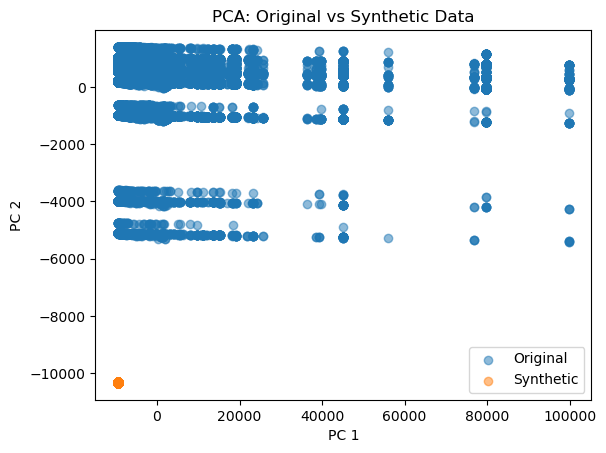

In [171]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA on the original minority class data
pca = PCA(n_components=2)
original_2d = pca.fit_transform(X_train_minority.cpu().numpy())

# Transform the synthetic data using the same PCA instance
synthetic_2d = pca.transform(synthetic_minority_data)

# Plot the PCA results
plt.scatter(original_2d[:, 0], original_2d[:, 1], alpha=0.5, label='Original')
plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], alpha=0.5, label='Synthetic')
plt.legend()
plt.title('PCA: Original vs Synthetic Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


In [172]:
import seaborn as sns
from scipy.stats import ks_2samp

# Ensure data is in NumPy format for KS test
X_train_minority_np = X_train_minority.cpu().numpy()  # Convert PyTorch tensor to NumPy
synthetic_minority_data_np = synthetic_minority_data  # Assuming this is already a NumPy array

# Updated KS test for each feature
for i in range(X_train_minority_np.shape[1]):
    stat, p_value = ks_2samp(X_train_minority_np[:, i], synthetic_minority_data_np[:, i])
    print(f"Feature {i}: KS Statistic = {stat:.4f}, p-value = {p_value:.4e}")


Feature 0: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 1: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 2: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 3: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 4: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 5: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 6: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 7: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 8: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 9: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 10: KS Statistic = 0.6416, p-value = 0.0000e+00
Feature 11: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 12: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 13: KS Statistic = 0.9945, p-value = 0.0000e+00
Feature 14: KS Statistic = 0.9939, p-value = 0.0000e+00
Feature 15: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 16: KS Statistic = 1.0000, p-value = 0.0000e+00
Feature 17: KS Statistic = 1.0000, p-value = 0.0000e+00
Fe

In [174]:
# Check the number of labels (0 and 1) in the balanced dataset
label_counts = pd.Series(y_balanced).value_counts()
print("Number of samples for each label:")
print(label_counts)

# Save the balanced dataset to CSV
X_balanced = X_balanced.astype('float32')
y_balanced = y_balanced.astype('int8')

balanced_data = pd.DataFrame(
    data=np.hstack((X_balanced, y_balanced.reshape(-1, 1))),
    columns=[f'feature_{i}' for i in range(X_balanced.shape[1])] + ['label']
)


Number of samples for each label:
0.0    3766407
1.0      47567
Name: count, dtype: int64


In [175]:
balanced_data.columns = ['city', 'series_dev', 'emui_dev', 'device_name', 'device_size', 'net_type',
                          'creat_type_cd', 'slot_id', 'spread_app_id', 'app_second_class', 'u_refreshTimes',
                          'u_feedLifeCycle', 'user_id_count', 'task_id_count', 'adv_id_count',
                          'user_id_task_id_nunique', 'user_id_adv_prim_id_nunique', 'user_id_slot_id_nunique',
                          'user_id_spread_app_id_nunique', 'age_task_id_nunique', 'age_adv_id_nunique',
                          'gender_task_id_nunique', 'label']
print(balanced_data)

          city  series_dev  emui_dev  device_name  device_size  net_type  \
0        411.0        16.0      35.0        324.0       2401.0       7.0   
1        306.0        30.0      35.0        278.0       2482.0       7.0   
2        106.0        21.0      12.0        310.0       2231.0       7.0   
3        431.0        32.0      19.0        312.0       1135.0       7.0   
4        263.0        30.0      28.0        344.0       2032.0       7.0   
...        ...         ...       ...          ...          ...       ...   
3813969  372.0        21.0      30.0        338.0       2305.0       7.0   
3813970  352.0        34.0      28.0        280.0       2117.0       7.0   
3813971  297.0        19.0      30.0        228.0       1786.0       7.0   
3813972  328.0        20.0      19.0        190.0       1704.0       6.0   
3813973  319.0        27.0      11.0        319.0       2117.0       7.0   

         creat_type_cd  slot_id  spread_app_id  app_second_class  ...  \
0             

In [176]:
print(balanced_data['label'].value_counts())

label
0.0    3766407
1.0      47567
Name: count, dtype: int64


In [177]:
#selected_features = ['user_id', 'gender', 'residence', 'city', 'city_rank', 'device_size', 'adv_id', 'adv_prim_id', 'inter_type_cd', 'spread_app_id', 'app_second_class', 'u_refreshTimes', 'user_id_count', 'gender_count', 'city_count', 'series_dev_count', 'adv_id_count', 'creat_type_cd_count', 'adv_prim_id_count', 'inter_type_cd_count', 'slot_id_count', 'hispace_app_tags_count', 'age_site_id_nunique', 'user_id_adv_prim_id_nunique_target_enc', 'user_id_slot_id_nunique_target_enc', 'age_adv_prim_id_nunique_target_enc', 'age_site_id_nunique_target_enc', 'gender_adv_id_nunique_target_enc', 'task_id_target_enc', 'app_second_class_target_enc', 'city_target_enc', 'user_id_target_enc', 'user_id_count_target_enc']
#balanced_data.to_csv('D:/stats_c161/balanced_dataset.csv', index=False)
print("Balanced dataset saved as 'balanced_dataset.csv'")


Balanced dataset saved as 'balanced_dataset.csv'


In [178]:
# selected_features =  ['city', 'series_dev', 'emui_dev', 'device_name', 'device_size', 'net_type',
#                           'creat_type_cd', 'slot_id', 'spread_app_id', 'app_second_class', 'u_refreshTimes',
#                           'u_feedLifeCycle', 'user_id_count', 'task_id_count', 'adv_id_count',
#                           'user_id_task_id_nunique', 'user_id_adv_prim_id_nunique', 'user_id_slot_id_nunique',
#                           'user_id_spread_app_id_nunique', 'age_task_id_nunique', 'age_adv_id_nunique',
#                           'gender_task_id_nunique']

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

def evaluate(method, X_train, y_train, X_test, y_test, random_state=123):
    # Ensure data scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model selection
    if method == "logistic_regression":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
    elif method == "random_forest":
        model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif method == "catboost":
        model = CatBoostClassifier(verbose=0, random_state=random_state)
    else:
        raise ValueError("Unsupported method. Choose from: 'logistic_regression', 'random_forest', 'catboost'.")
    
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions and metrics
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    metrics = {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }
    
    print(f"Evaluation metrics for {method}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.5f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color="b", label=f"{method} ROC Curve (AUC = {metrics['ROC-AUC']:.2f})")
    plt.plot([0, 1], [0, 1], color="r", linestyle="--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{method.capitalize()} ROC Curve")
    plt.legend()
    plt.show()
    
    return metrics


In [210]:
# balanced_data = balanced_data.drop(columns=['source']) 
# print(balanced_data)

Evaluation metrics for logistic_regression:
ROC-AUC: 0.75310
Accuracy: 0.50000
Recall: 0.00000
F1-Score: 0.00000


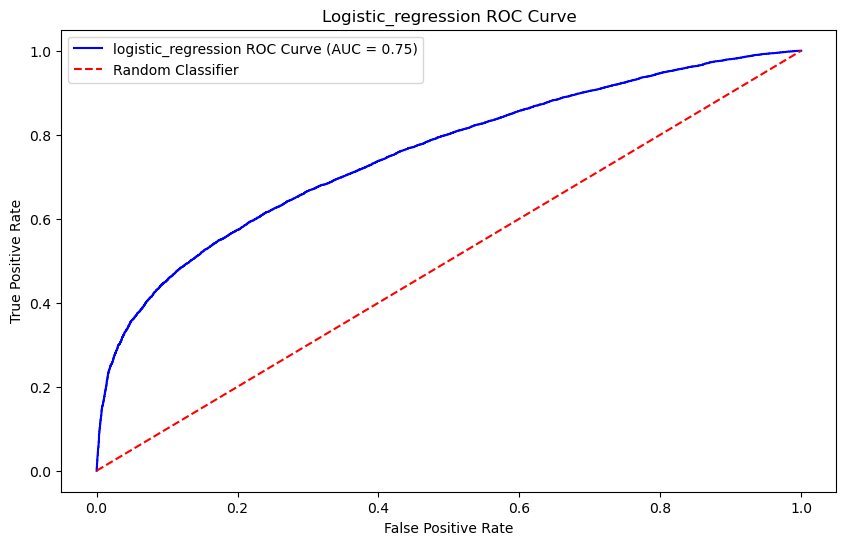

In [212]:
metrics = evaluate("logistic_regression", balanced_data.drop(columns=['label']), balanced_data['label'] , X_test, y_test)

Evaluation metrics for random_forest:
ROC-AUC: 0.74650
Accuracy: 0.55588
Recall: 0.11445
F1-Score: 0.20489


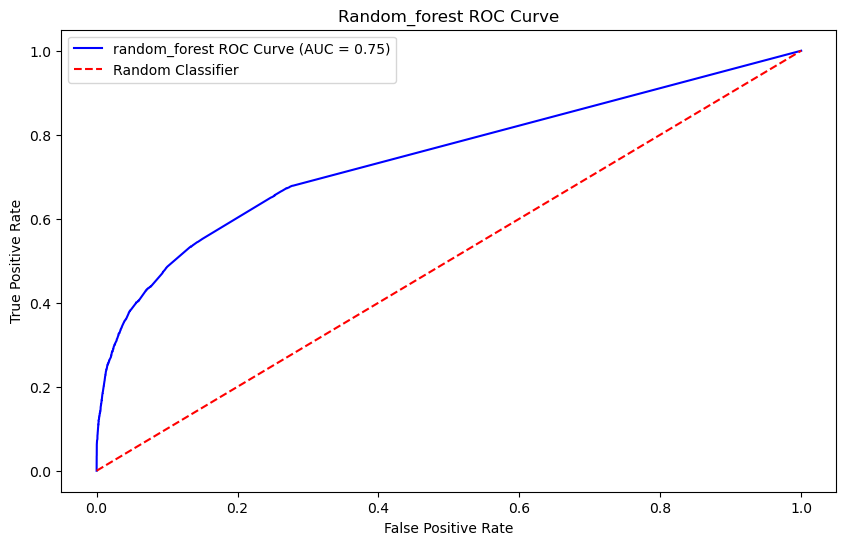

In [213]:
metrics = evaluate("random_forest", balanced_data.drop(columns=['label']), balanced_data['label'] , X_test, y_test)

Evaluation metrics for catboost:
ROC-AUC: 0.81274
Accuracy: 0.52443
Recall: 0.04945
F1-Score: 0.09418


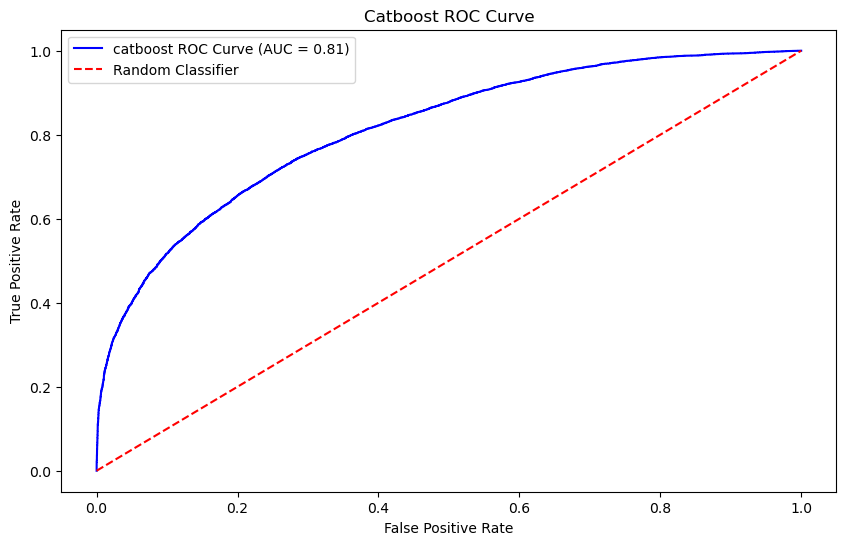

In [214]:
metrics = evaluate("catboost", balanced_data.drop(columns=['label']), balanced_data['label'] , X_test, y_test)

In [184]:
def plot_pca(real_data, synthetic_data):
    # Add source labels
    real_data["source"] = "Real"
    synthetic_data["source"] = "Synthetic"

    # Combine datasets
    combined_data = pd.concat([real_data, synthetic_data], ignore_index=True)

    numeric_data = combined_data.select_dtypes(include="number").dropna()

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(numeric_data)

    # Create DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["source"] = combined_data["source"]

    # Plot PCA results
    plt.figure(figsize=(10, 6))
    for source, color in zip(["Real", "Synthetic"], ["blue", "orange"]):
        subset = pca_df[pca_df["source"] == source]
        plt.scatter(subset["PCA1"], subset["PCA2"], label=source, alpha=0.5, s=10, color=color)

    plt.title("PCA of Real vs Synthetic Data")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()


def ks_test(real_data, synthetic_data):
    real_data_numeric = real_data.select_dtypes(include="number").dropna()
    synthetic_data_numeric = synthetic_data.select_dtypes(include="number").dropna()

    ks_results = []
    for i in range(real_data_numeric.shape[1]):
        stat, p_value = ks_2samp(real_data_numeric.iloc[:, i], synthetic_data_numeric.iloc[:, i])
        ks_results.append({"Feature": real_data_numeric.columns[i], "KS Statistic": stat, "p-value": p_value})

    ks_df = pd.DataFrame(ks_results)
    print(ks_df)
    return ks_df


def kde_plot(real_data, synthetic_data, num_features_to_plot=5):
    real_data_numeric = real_data.select_dtypes(include="number").dropna()
    synthetic_data_numeric = synthetic_data.select_dtypes(include="number").dropna()

    num_features_to_plot = min(num_features_to_plot, real_data_numeric.shape[1])

    for idx in range(num_features_to_plot):
        plt.figure(figsize=(8, 5))
        sns.kdeplot(real_data_numeric.iloc[:, idx], label="Original Minority", fill=True)
        sns.kdeplot(synthetic_data_numeric.iloc[:, idx], label="Synthetic Minority", fill=True)
        plt.title(f"Distribution of Feature {real_data_numeric.columns[idx]}")
        plt.legend()
        plt.show()

C:\Users\26069\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


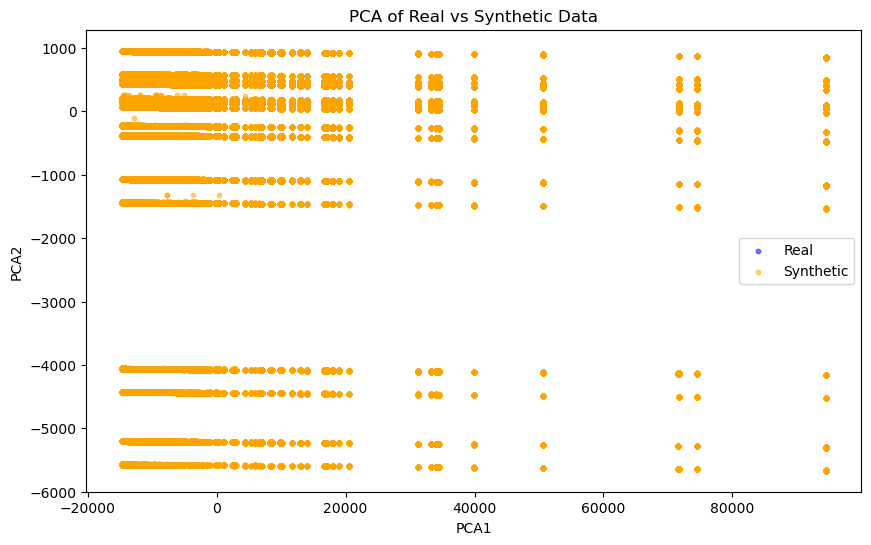

In [185]:
plot_pca(test, balanced_data)

In [186]:
ks_test(test, balanced_data)

                          Feature  KS Statistic        p-value
0                            city      0.003936   8.559819e-01
1                      series_dev      0.021136   1.326174e-09
2                        emui_dev      0.015075   4.269877e-05
3                     device_name      0.012550   1.158085e-03
4                     device_size      0.017830   5.867948e-07
5                        net_type      0.012881   7.777132e-04
6                   creat_type_cd      0.113041  1.486538e-263
7                         slot_id      0.088143  3.099319e-160
8                   spread_app_id      0.027865   2.234567e-16
9                app_second_class      0.038617   4.600915e-31
10                 u_refreshTimes      0.143287   0.000000e+00
11                u_feedLifeCycle      0.121999  4.713884e-307
12                  user_id_count      0.185518   0.000000e+00
13                  task_id_count      0.043766   8.844116e-40
14                   adv_id_count      0.043766   8.844

,Feature,KS Statistic,p-value
0,city,0.003936,8.559819e-01
1,series_dev,0.021136,1.326174e-09
2,emui_dev,0.015075,4.269877e-05
3,device_name,0.012550,1.158085e-03
4,device_size,0.017830,5.867948e-07
5,net_type,0.012881,7.777132e-04
6,creat_type_cd,0.113041,1.486538e-263
7,slot_id,0.088143,3.099319e-160
8,spread_app_id,0.027865,2.234567e-16
9,app_second_class,0.038617,4.600915e-31


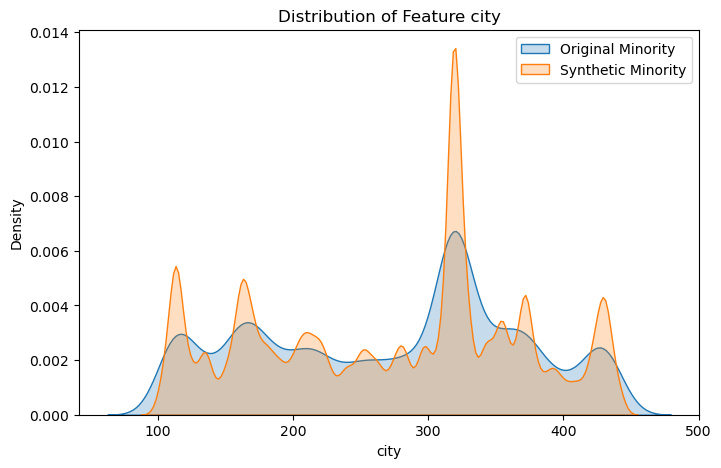

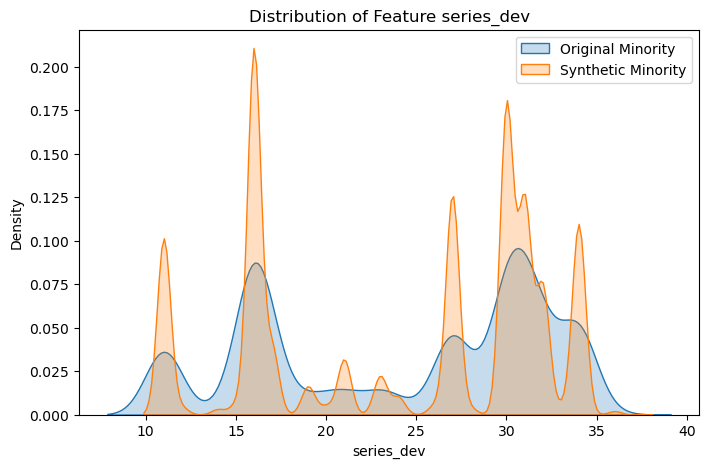

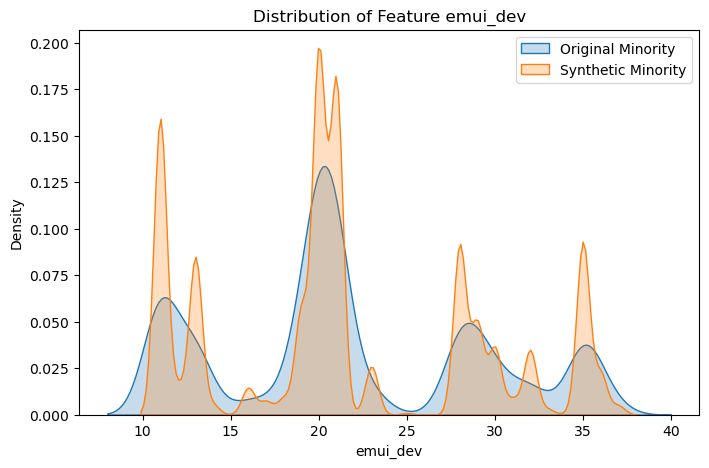

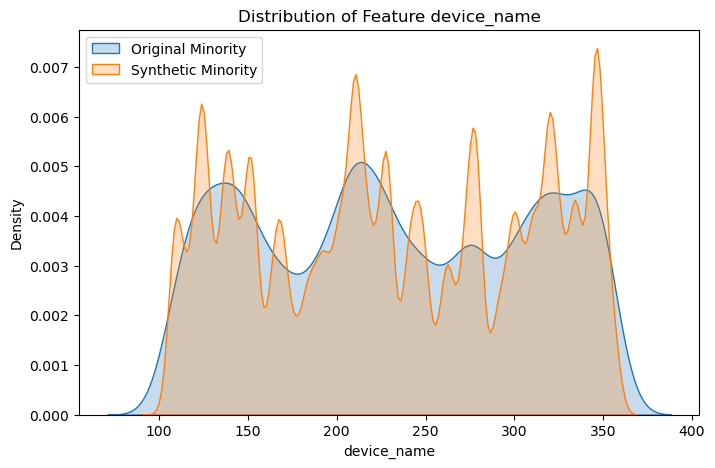

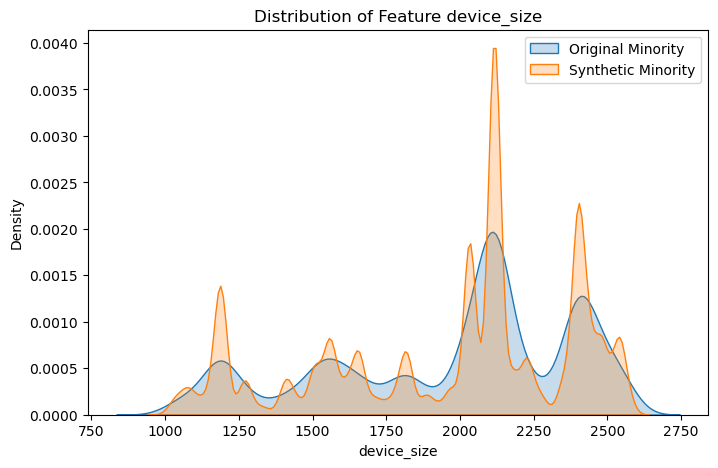

In [187]:
kde_plot(test, balanced_data)